In [165]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [166]:
df = pd.read_csv('./data/cc_info.csv')

In [167]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [186]:
df.MINIMUM_PAYMENTS = df.MINIMUM_PAYMENTS.fillna(np.mean(df.MINIMUM_PAYMENTS))
df.CREDIT_LIMIT = df.CREDIT_LIMIT.fillna(np.mean(df.CREDIT_LIMIT))

In [187]:
feature_names = df.drop(columns=['CUST_ID']).columns 
filtered_features = []

In [188]:
tenure_bins = pd.get_dummies(df.TENURE)
tenure_bins.columns = ['tenure_'+str(i) for i in tenure_bins.columns]

In [189]:
for feature in feature_names:
    if 'FREQUENCY' not in feature and not feature=='TENURE':
        df['log_'+feature] = df[feature].apply(lambda x: np.log1p(x))
        filtered_features +=['log_'+feature]
    else:
        filtered_features +=[feature]

In [190]:
from sklearn.decomposition import PCA
df_final = df[filtered_features].drop(columns='TENURE')
df_final = pd.concat([df_final, tenure_bins], axis=1)
x = np.array(df_final)
# x = np.hstack([x, np.array(tenure_bins)])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [191]:
#Kmeans clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(principalDf)
y_km = kmeans.fit_predict(principalDf)

Text(0, 0.5, 'PC2')

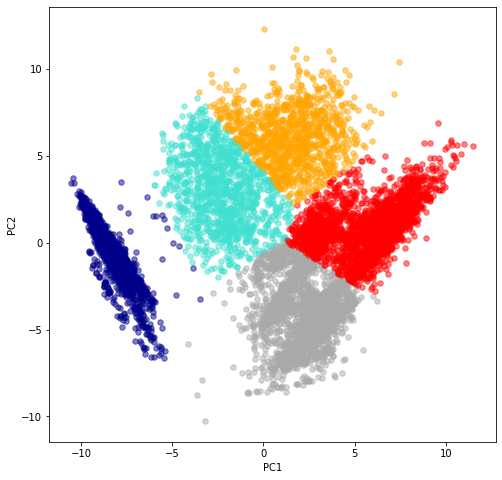

In [192]:
fig = plt.figure(figsize=(8, 8))
points = np.array(principalDf)
plt.scatter(points[y_km == 0, 0],
            points[y_km == 0, 1],
            s=30,
            c='turquoise',
            alpha=.5)
plt.scatter(points[y_km == 1, 0],
            points[y_km == 1, 1],
            s=30,
            c='darkgray',
            alpha=.5)
plt.scatter(points[y_km == 2, 0],
            points[y_km == 2, 1],
            s=30,
            c='darkblue',
            alpha=.5)
plt.scatter(points[y_km == 3, 0],
            points[y_km == 3, 1],
            s=30,
            c='red',
            alpha=.5)
plt.scatter(points[y_km == 4, 0],
            points[y_km == 4, 1],
            s=30,
            c='orange',
            alpha=.5)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [193]:
df_final['cluster'] = y_km

In [194]:
df_copy = df_final.copy()
df_copy = df_copy.reindex(y_km)

/Users/afrah/miniconda3/envs/test/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


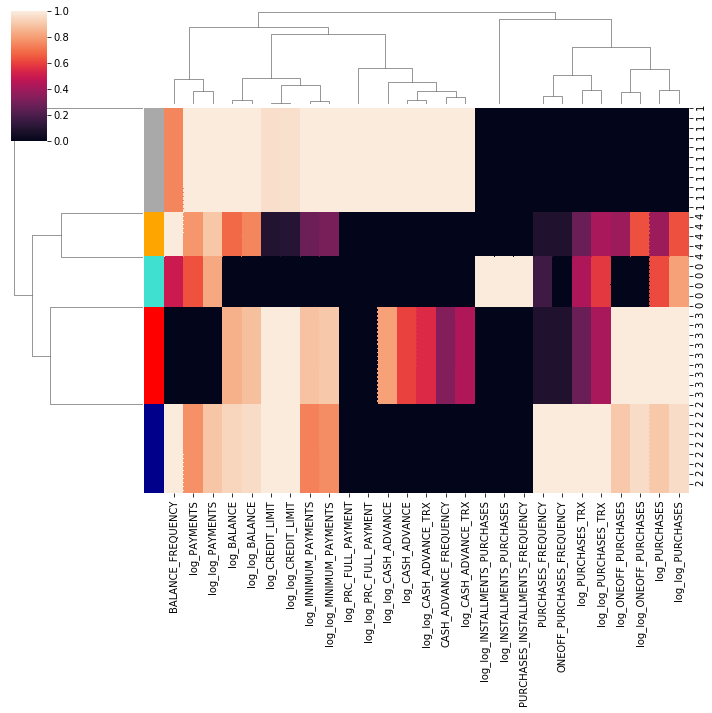

In [198]:
dict_features = {0:'turquoise',1:'darkgray',2:'darkblue',3:'red',4:'orange'}
row_colors = df_copy.index.map(dict_features)
sns.clustermap(data=df_copy.drop(columns=['cluster']+list(tenure_bins.columns)),row_colors=row_colors, standard_scale=1)